In [71]:
from pathlib import Path

model_name, ds_name = "resnet18", "cifar10"
path = Path("export-out") / model_name / ds_name

In [72]:
from glob import glob
from regex import match
import pandas as pd
import numpy as np
import json


def _is_epoch_analysis(p: str) -> bool:
    return Path(p).is_dir() and (match(r".*/\d+$", p) is not None)


analysis_paths = list(filter(_is_epoch_analysis, glob(str(path / "*"))))

dfs = []
for p in analysis_paths:
    m = match(r".*/(\d+)$", p)
    assert m is not None
    epoch = int(m.group(1))
    with (Path(p) / "svc" / "svc.json").open(mode="r", encoding="utf-8") as fp:
        doc = json.load(fp)  # Prevents loading numpy arrays
    data = [
        [epoch, k, np.mean([d["score"] for d in v])] for k, v in doc.items()
    ]
    df = pd.DataFrame(data, columns=["epoch", "submodule", "mean_score"])
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

In [73]:
metrics = pd.read_csv(
    path / "model" / "csv_logs" / model_name / "version_0" / "metrics.csv"
)
metrics.drop(columns=["train/loss"], inplace=True)
metrics = metrics.groupby("epoch").tail(1)
metrics.reset_index(inplace=True, drop=True)
best_epoch = metrics["val/loss"].argmin()

/tmp/ipykernel_2086875/2686934217.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  figure.set_xticklabels(figure.get_xticklabels(), rotation=45)


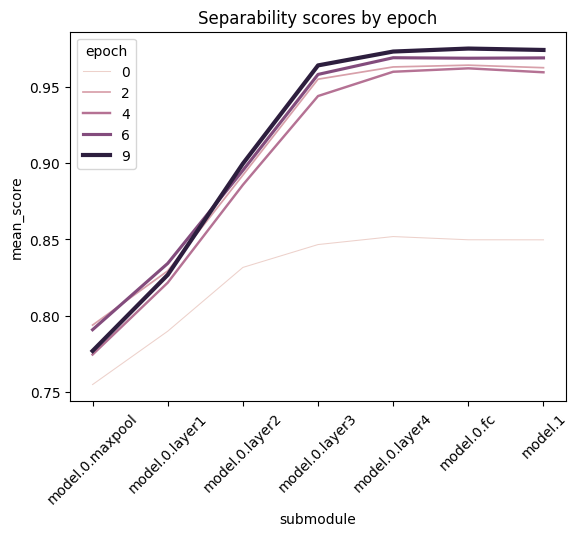

In [82]:
import seaborn as sns

e = np.linspace(0, best_epoch, num=5, dtype=int)

figure = sns.lineplot(
    df[df["epoch"].isin(e)],
    x="submodule",
    y="mean_score",
    hue="epoch",
    size="epoch",
)
figure.set(title="Separability scores by epoch")
figure.set_xticklabels(figure.get_xticklabels(), rotation=45)
figure.get_figure().savefig(path / "separability_epoch.png")

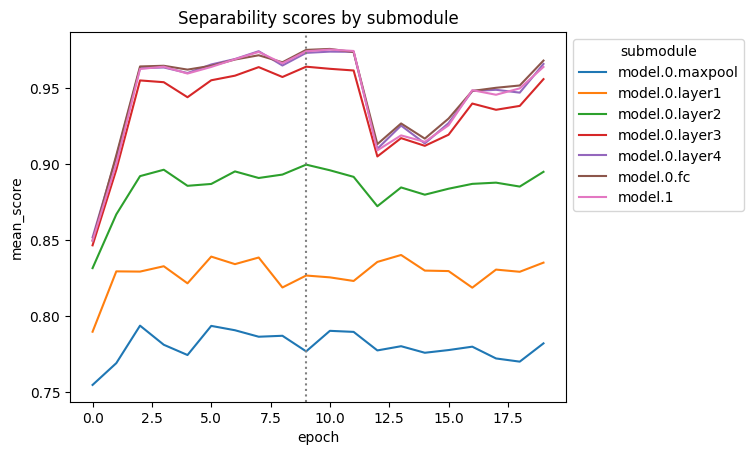

In [83]:
figure = sns.lineplot(df, x="epoch", y="mean_score", hue="submodule")
sns.move_legend(figure, "upper left", bbox_to_anchor=(1, 1))
figure.axvline(best_epoch, linestyle=":", color="gray")
figure.set(title="Separability scores by submodule")
figure.get_figure().savefig(path / "separability_submod.png")

/home/cedric/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


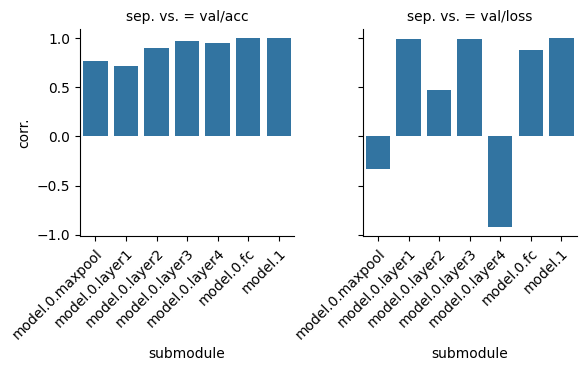

In [84]:
c = []
submodules = df[df["epoch"] == 0]["submodule"]
for s in submodules:
    a = df[df["submodule"] == s]["mean_score"]
    c.append(
        [
            s,
            metrics["val/acc"].corr(a),
            metrics["val/loss"].corr(a),
        ],
    )
correlations = pd.DataFrame(
    c,
    columns=[
        "submodule",
        "val/acc",
        "val/loss",
    ],
)
correlations = correlations.melt(
    id_vars=["submodule"],
    var_name="sep. vs.",
    value_name="corr.",
)

grid = sns.FacetGrid(correlations, col="sep. vs.")
grid.map(sns.barplot, "submodule", "corr.")
for ax in grid.axes_dict.values():
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        rotation_mode="anchor",
        ha="right",
    )
figure.get_figure().savefig(path / "correlations.png")

In [77]:
import bokeh.plotting as bk
import bokeh.io

bokeh.io.output_notebook()

Loading BokehJS ...

In [78]:
import turbo_broccoli as tb

data = {}
for p in analysis_paths:
    m = match(r".*/(\d+)$", p)
    assert m is not None
    epoch = int(m.group(1))
    if epoch > best_epoch:
        continue
    doc = tb.load_json(Path(p) / "tsne" / "plots.json")
    plots = list(doc.values())
    for p in plots:
        p.height, p.width = 200, 200
        p.grid.visible, p.axis.visible = False, False
        # p.title = f"[{epoch}/{best_epoch}] {p.title.text}"
    data[epoch] = plots

figures = [data[i] for i in range(best_epoch)]
plot = bk.gridplot(figures)
bk.show(plot)

In [79]:
from bokeh.io import export_png

export_png(plot, filename=path / "tsne_all.png")

'/home/cedric/repositories/nlnas/export-out/resnet18/cifar10/tsne_all.png'